# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=63.87557484087011, mobile=True), User(purchased=False, time_on_site=265.64284173007064, mobile=True), User(purchased=False, time_on_site=157.01396461892273, mobile=False), User(purchased=False, time_on_site=178.2909634242509, mobile=True), User(purchased=False, time_on_site=287.09445423255255, mobile=True), User(purchased=False, time_on_site=512.6521183143507, mobile=False), User(purchased=False, time_on_site=477.72148268739596, mobile=False), User(purchased=False, time_on_site=146.94726361367597, mobile=True), User(purchased=False, time_on_site=434.0161358622772, mobile=False), User(purchased=False, time_on_site=47.305973182139894, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,63.875575,True
1,False,265.642842,True
2,False,157.013965,False
3,False,178.290963,True
4,False,287.094454,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2109450715984105,5.464638207539852,5.513221235103223,5.641149731239146,5.74997630784716,5.889838003482058,6.284004561260051,6.829960631216221,7.02578113512759,7.151369999976382,...,581.3393098400824,582.0080169010536,582.0361052263339,582.3490557355324,583.6166002395104,589.1527437334952,589.7271186218869,590.4120394256123,592.1207160828138,595.1646715124776
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,258,304,178,43,60
True,60,61,23,7,6


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
!pip install seaborn --upgrade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Use what we did live in lecture as an example
df = pd.read_csv('https://raw.githubusercontent.com/DanielleRomanoff/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df.head()

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [2]:
df.head()  # Look up docs on read csv, import without the index

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [3]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [4]:
df.shape

(1200, 4)

In [5]:
list(df)

['Unnamed: 0', 'age', 'weight', 'exercise_time']

In [0]:
df.applymap(np.isreal)

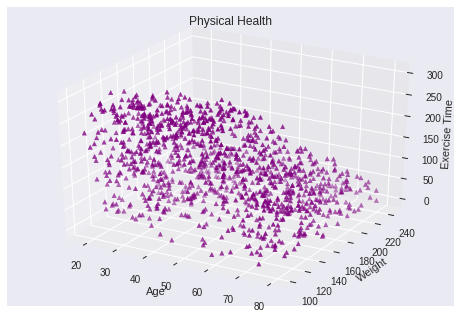

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

# for c, m, zlow, zhigh in [('r', 'o', 0, n), ('b', '^', 0, 1200)]:
x = df[['age']] 
y = df[['weight']]
z = df[['exercise_time']]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, marker = '^', color = 'purple') # transparency

ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time')
ax.set_title('Physical Health')

plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


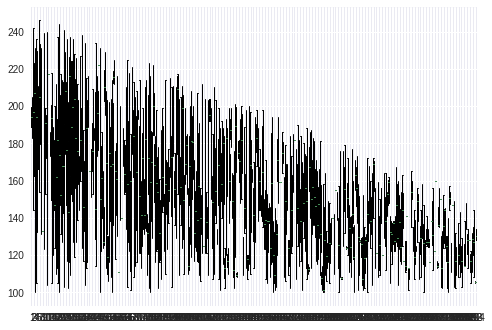

In [8]:
gp = df['weight'].groupby(df['exercise_time'])  # Look at uniques in the exercise time feature exercise time groups 4 or 5 ranges of exercise time
# mean age, mean weight extremes
plt.boxplot([group for name, group in gp])
plt.show()

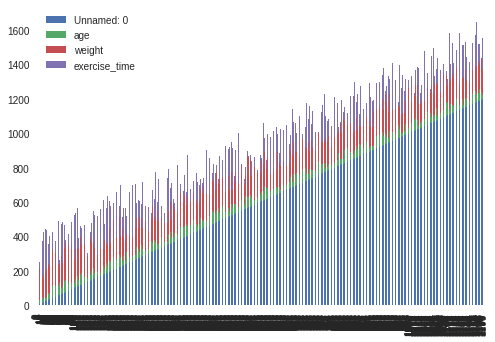

In [9]:
df.plot(kind='bar', stacked = True) # groupby . categorize these drop Unnamed as it's an index exercise time groups mean age and weight

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)